PS9
Collaborators: 

Problem 1

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import math

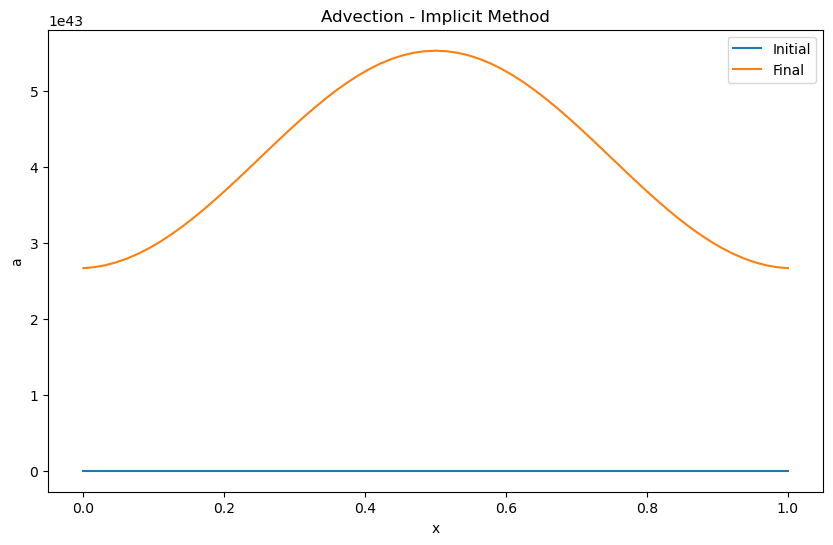

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def create_matrix(nx, u, dt, dx):
    diag_val = 1 + u * dt / dx
    off_diag_val = -u * dt / dx
    diagonals = [off_diag_val*np.ones(nx-1), diag_val*np.ones(nx), off_diag_val*np.ones(nx-1)]
    A = diags(diagonals, offsets=[-1, 0, 1], shape=(nx, nx), format='csc')
    A[0, -1] = off_diag_val
    A[-1, 0] = off_diag_val
    return A

def init_cond_gaussian(nx, dx):
    x = np.linspace(0, 1, nx)
    a_initial = np.exp(-((x - 0.5)**2) / (0.1**2))
    return a_initial

# Parameters for the problem
nx = 65  # Number of grid points
u = 1.0  # Advection speed
dt = 0.01  # Time step size
dx = 1.0 / (nx - 1)  # Spatial step size
tmax = 1.0  # Total time for the simulation
nt = int(tmax / dt)  # Total number of time steps

# Create the matrix A
A = create_matrix(nx, u, dt, dx)

# Initial condition
a = init_cond_gaussian(nx, dx)

# Prepare for plotting
x = np.linspace(0, 1, nx)
plt.figure(figsize=(10, 6))
plt.plot(x, a, label='Initial')

# Time-stepping loop
for _ in range(nt):
    # Solve the system Ax = b
    a = spsolve(A, a)

# Plotting the final state
plt.plot(x, a, label='Final')
plt.legend()
plt.xlabel('x')
plt.ylabel('a')
plt.title('Advection - Implicit Method')
plt.show()




In [99]:
#Problem 1 part 3

class FDGrid(object):
    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):
        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx
        # Python is zero-based (duh)
        # Make easy intergers to know where the real data lives (KNOCK AT ITS DOOR)
        self.ilo = ng
        self.ihi = ng + nx - 1
        # Physical Coords
        self.dx = (xmax - xmin)/(nx - 1)
        self.x = xmin + (np.arange(nx + 2*ng) - ng)*self.dx
        # Storage for the solution
        self.a = np.zeros((nx + 2*ng), dtype=np.float64)
        
    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx + 2*self.ng), dtype=np.float64)
        
    def fill_BCs(self):
        """ fill the a single ghostcell with periodic boundary conditions """
        self.a[self.ilo - 1] = self.a[self.ihi - 1]
        self.a[self.ihi + 1] = self.a[self.ilo + 1]
        
def init_cond_gaussian(x):
    return np.exp(-((x - 0.5)**2)/(0.1**2))

"""
Input C and nx = grid points, produces a plot
"""
def create_plot(nx, C, method, error = False):
    g  = FDGrid(nx, ng)
    # time info
    dt = C*g.dx/u
    t  = 0.0
    tmax = 1.0*(g.xmax - g.xmin)/u

    # initialize the data -- gaussian
    for i in range(0,g.ihi):
        gaussian = math.exp(-(g.x[i]-0.5)**2/(0.1**2))
        g.a[i] = gaussian


    ainit = g.a.copy()
    # evolution loop
    anew = g.scratch_array()
    while t < tmax:
        # fill the boundary conditions
        g.fill_BCs()
        # loop over zones: note since we are periodic and both endpoints
        # are on the computational domain boundary, we don't have to
        # update both g.ilo and g.ihi -- we could set them equal instead.
        # But this is more general
        for i in range(g.ilo, g.ihi+1):
            if method == 'L-W':
                anew[i] = g.a[i] - 0.5*C*(g.a[i+1] - g.a[i-1]) + 0.5*C**2 *(g.a[i+1] - 2*g.a[i] + g.a[i-1])
            # upwind
            elif i == g.ilo:
                anew[i] = g.a[i-1]
            elif method == 'upwind_implicit':
                anew[i] = (g.a[i] + (C*anew[i-1]))/(1+C)
            # store the updated solution
        g.a[:] = anew[:]
        t += dt
    if error:
        return calculate_error(g.a[g.ilo:g.ihi+1], ainit[g.ilo:g.ihi+1], g.dx)

    plt.plot(g.x[g.ilo:g.ihi+1], ainit[g.ilo:g.ihi+1], ls=":", c = 'y')
    plt.plot(g.x[g.ilo:g.ihi+1], g.a[g.ilo:g.ihi+1], c = 'b')
    plt.show()

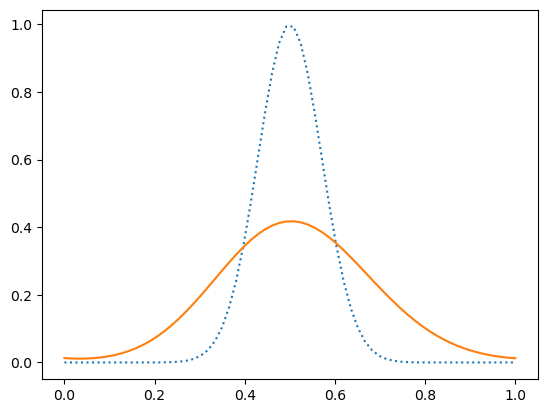

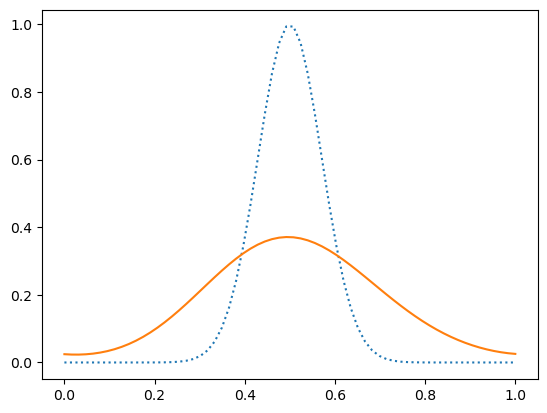

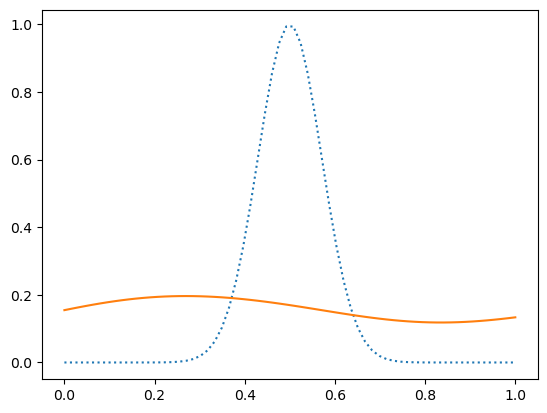

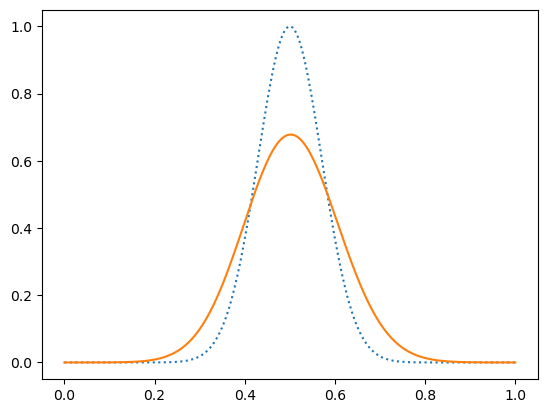

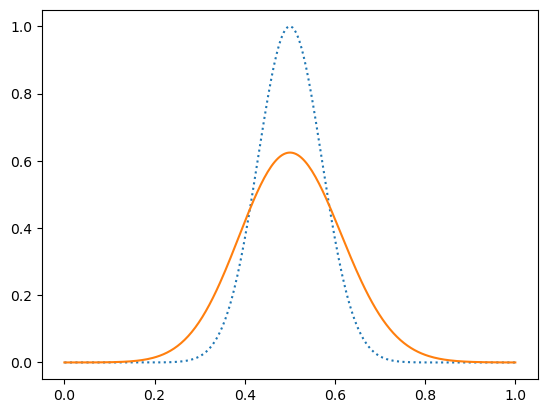

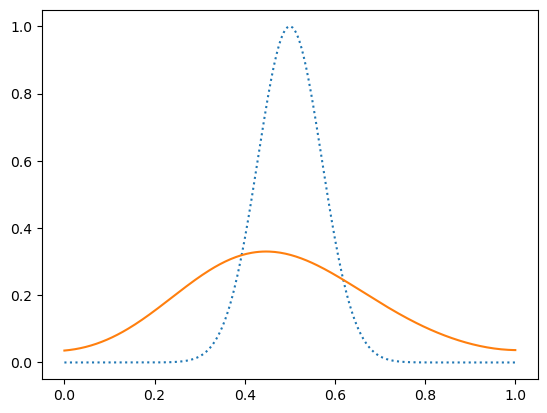

In [62]:
# Upwind implicit method

# Grid points = 64, C = 0.5,1,10
create_plot(0.5, 64, 'upwind_implicit')
create_plot(1, 64, 'upwind_implicit')
create_plot(10, 64, 'upwind_implicit')

# Grid points = 256, C = 0.5,1,10
create_plot(0.5, 256, 'upwind_implicit')
create_plot(1, 256, 'upwind_implicit')
create_plot(10, 256, 'upwind_implicit')

Problem 2

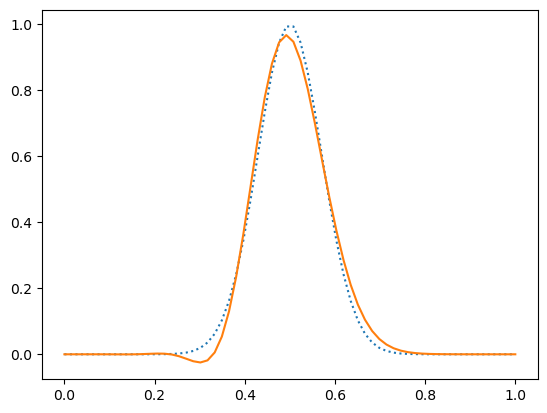

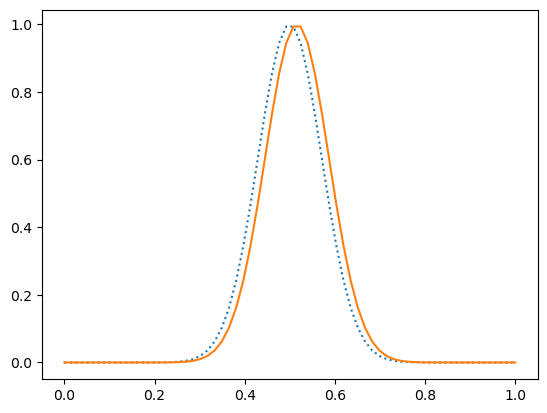

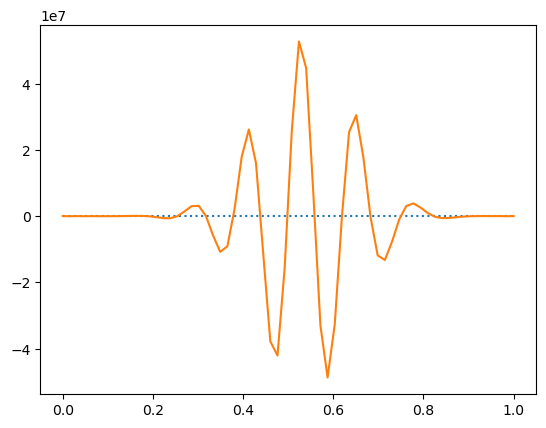

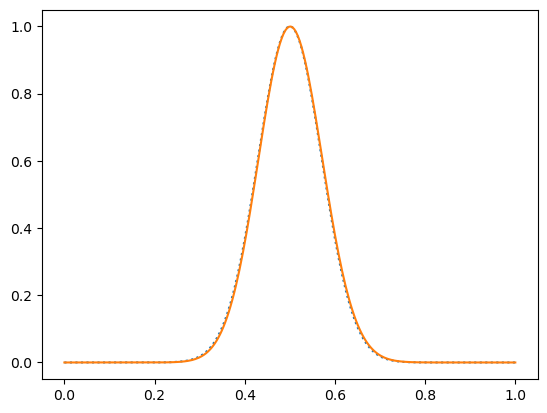

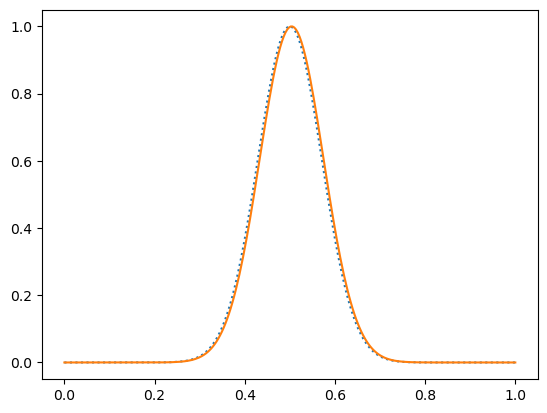

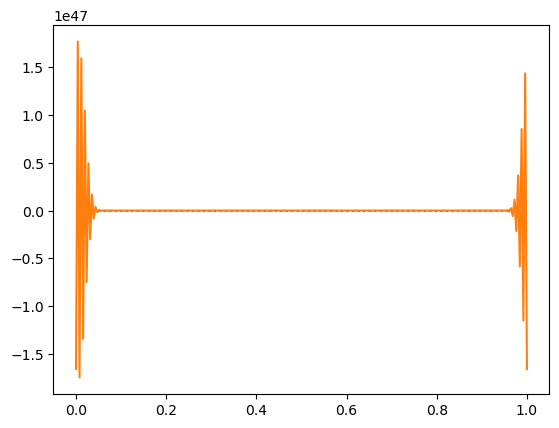

In [64]:
# Lax-Wendroff method

# Grid points = 64, C = 0.5,1,10
create_plot(0.5, 64, 'LW')
create_plot(1, 64, 'LW')
create_plot(10, 64, 'LW')

# Grid points = 256, C = 0.5,1,10
create_plot(0.5, 256, 'LW')
create_plot(1, 256, 'LW')
create_plot(10, 256, 'LW')

In [101]:
# Calculate error 
def calculate_error(array_1, array_2, dx):
    summation = 0
    for i in range(0,len(array_1-1)):
        summation+= (array_1[i]-array_2[i])**2
    return (dx*summation)**(1/2)

In [ ]:
errors = []
for N in range(65, 1000, 5):
    errors.append(create_plot(N, 0.5, method = "L-W", error = True))

In [ ]:
plt.plot(range(65, 1000, 5), errors, c = 'y')
plt.show()